Notebook to train the model.

Dataset:
    lib/Datasets.py:
        EEGDataset

Models:
    lib/models/EEG_Net_CNN.py : EEG_Net_CNN - a simple convolutional neural network [conv -> conv -> conv -> dense] with ELU activation, pooling, and batch normalization

In [1]:
# Packages
from lib.models.EEG_Net_CNN import EEG_Net_CNN
import matplotlib.pyplot as plt
from lib.utils import load_data, train, test
from lib.Datasets import EEGDataset
from lib.DataObject import DataObject
import lib.DataObjectUtils as util
import torch
import pickle
import torch.nn as nn
from lib.DataHandler import DataAcquisitionHandler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# load pickle files
filepath = "C:/Users/c25th/code/P300_BCI_Speller/data/dataloaders/"
date = "2023-11-22"
train_filename = "train_loader_"+date+".txt"
val_filename = "val_loader_"+date+".txt"
test_filename = "test_loader_"+date+".txt"

with open(filepath + train_filename, 'rb') as f:
    train_loader = pickle.load(f)

with open(filepath + val_filename, 'rb') as f:
    val_loader = pickle.load(f)

with open(filepath + test_filename, 'rb') as f:
    test_loader = pickle.load(f)

In [3]:
# initialize model
model = EEG_Net_CNN()

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1 - Train Loss: 0.7252 - Train Accuracy: 0.4835 - Val Loss: 0.6934 - Val Accuracy: 0.4118
Epoch 2 - Train Loss: 0.6888 - Train Accuracy: 0.5165 - Val Loss: 0.6514 - Val Accuracy: 0.6765
Epoch 3 - Train Loss: 0.7072 - Train Accuracy: 0.4615 - Val Loss: 0.6205 - Val Accuracy: 0.6765
Epoch 4 - Train Loss: 0.7037 - Train Accuracy: 0.4945 - Val Loss: 0.6951 - Val Accuracy: 0.6765
Epoch 5 - Train Loss: 0.7020 - Train Accuracy: 0.5531 - Val Loss: 0.6258 - Val Accuracy: 0.6765
Epoch 6 - Train Loss: 0.6969 - Train Accuracy: 0.4982 - Val Loss: 0.7055 - Val Accuracy: 0.3529
Epoch 7 - Train Loss: 0.6927 - Train Accuracy: 0.5568 - Val Loss: 0.6468 - Val Accuracy: 0.6471
Epoch 8 - Train Loss: 0.7030 - Train Accuracy: 0.4872 - Val Loss: 0.7219 - Val Accuracy: 0.6765
Epoch 9 - Train Loss: 0.6819 - Train Accuracy: 0.5165 - Val Loss: 0.6717 - Val Accuracy: 0.7059
Epoch 10 - Train Loss: 0.6943 - Train Accuracy: 0.5018 - Val Loss: 0.6651 - Val Accuracy: 0.7059


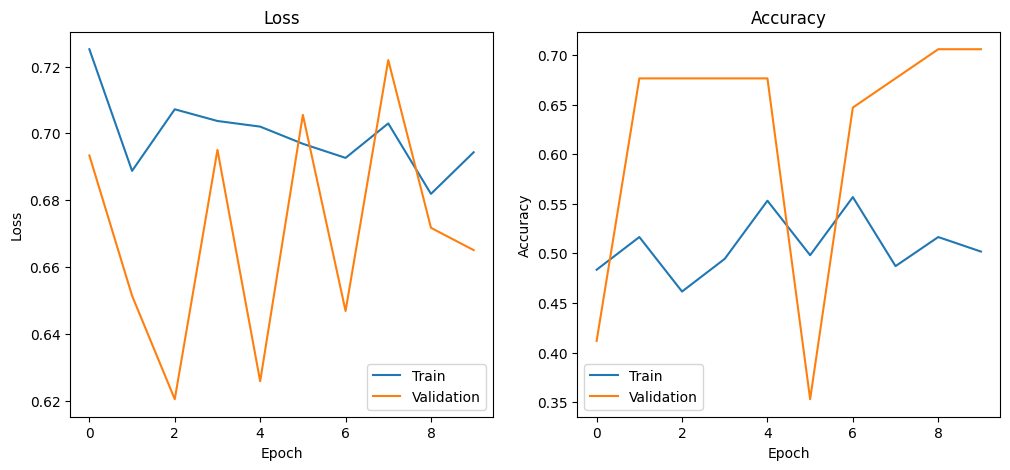

In [5]:
# def train_and_validate(train_dataloader, val_dataloader, model, loss_fn, optimizer, num_epochs, print_every=100):
train_losses, val_losses, train_accuracies, val_accuracies = train(
    train_loader, val_loader, model, loss_fn, optimizer, 10, print_every=-1)

In [6]:
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 45.7%, Avg loss: 0.691688 

